<a href="https://colab.research.google.com/github/lanyu0322/phd_semester1/blob/master/NYC_jobs_weekly_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install geopandas

     |████████████████████████████████| 921kB 4.8MB/s 
     |████████████████████████████████| 10.1MB 37.1MB/s 
     |████████████████████████████████| 11.9MB 26.0MB/s 
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=999f34fa030cfbde3b1caf3c64f8ca8f4f45962643c201c07627b07ef71fb9c9
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


In [0]:
import time
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import pyproj as proj
import pandas as pd

In [0]:
wname = "drive/My Drive/lwir/data/nyc_ratio/ny_wac_S000_JT00_2017.csv"
rname = "drive/My Drive/lwir/data/nyc_ratio/ny_rac_S000_JT00_2017.csv"
tname = "drive/My Drive/lwir/data/nyc_ratio/ny_od_main_JT00_2017.csv"

In [0]:
wdata = pd.read_csv(wname)
tdata = pd.read_csv(tname)
rdata = pd.read_csv(rname)

In [0]:
 # 1. merge wdata and rdata on the "geocode" columns (with suffixes "_w" and "_h") and fill NaNs with zeros (fillna is the method)
wdata = pd.read_csv(wname)
rdata = pd.read_csv(rname)
wdata.rename(columns = {'w_geocode': 'GEOID10'}, inplace=True)
rdata.rename(columns = {'h_geocode': 'GEOID10'}, inplace=True)

merged = pd.merge(wdata[["GEOID10", 'C000']], rdata[["GEOID10",'C000']], on="GEOID10", suffixes=["_w", "_h"], how='outer')

In [0]:
# # 2. sum the C000_w and C000_h columns and add the result to the output of 1.
merged[['C000_w', 'C000_h']] = merged[['C000_w','C000_h']].fillna(value=0) 
merged['total'] = merged['C000_w'] + merged['C000_h']

In [0]:
#3. sub-sample to only Manhattan
fname = "drive/My Drive/lwir/data/nyc_ratio/tl_2019_36_tabblock10/tl_2019_36_tabblock10.shp"
data = gp.read_file(fname)
ind = (data.COUNTYFP10 == "005") | (data.COUNTYFP10 == "047") | (data.COUNTYFP10 == "061") | (data.COUNTYFP10 == "081") | (data.COUNTYFP10 == "085") 
NYC_counties = data[ind]
#4. merge the output of 2. into the geodataframe of 4.
NYC_counties['GEOID10'] = NYC_counties['GEOID10'].astype(int)
sub = NYC_counties.merge(merged, on='GEOID10', how='left')
sub[['C000_w', 'C000_h']] = sub[['C000_w','C000_h']].fillna(value=0) 
sub['total'] = sub['C000_w'] + sub['C000_h']
sub.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,C000_w,C000_h,total
0,36,085,002001,2021,360850020012021,Block 2021,G5040,U,63217,U,S,13253,0,+40.6037814,-074.0663775,"POLYGON ((-74.06717 40.60409, -74.06715 40.604...",0.0,0.0,0.0
1,36,085,000800,3000,360850008003000,Block 3000,G5040,U,63217,U,S,19570,0,+40.6098673,-074.0645233,"POLYGON ((-74.06589 40.60968, -74.06367 40.610...",5.0,64.0,69.0
2,36,085,017012,2000,360850170122000,Block 2000,G5040,U,63217,U,S,14549,0,+40.5543529,-074.1694940,"POLYGON ((-74.17062 40.55457, -74.16852 40.554...",4.0,34.0,38.0
3,36,085,018701,2001,360850187012001,Block 2001,G5040,U,63217,U,S,15889,0,+40.6119578,-074.1234569,"POLYGON ((-74.12466 40.61213, -74.12411 40.612...",0.0,53.0,53.0
4,36,085,018701,2007,360850187012007,Block 2007,G5040,U,63217,U,S,18187,0,+40.6093225,-074.1245576,"POLYGON ((-74.12734 40.60897, -74.12636 40.609...",0.0,0.0,0.0


In [0]:
manhattan = sub.COUNTYFP10 =="061"
manhattan = sub[sub.COUNTYFP10 == "061"]
manhattan.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,C000_w,C000_h,total
36,36,061,002500,3002,360610025003002,Block 3002,G5040,U,63217,U,S,9868,0,+40.7093442,-073.9993024,"POLYGON ((-73.99978 40.70976, -73.99974 40.709...",0.0,159.0,159.0
37,36,061,000202,4001,360610002024001,Block 4001,G5040,U,63217,U,S,7935,0,+40.7124889,-073.9813708,"POLYGON ((-73.98171 40.71346, -73.98129 40.713...",3.0,168.0,171.0
38,36,061,001002,2004,360610010022004,Block 2004,G5040,U,63217,U,S,5402,0,+40.7161538,-073.9780982,"POLYGON ((-73.97854 40.71584, -73.97839 40.716...",0.0,128.0,128.0
39,36,061,018600,1001,360610186001001,Block 1001,G5040,U,63217,U,S,4678,0,+40.8002660,-073.9483890,"POLYGON ((-73.94862 40.80067, -73.94779 40.800...",0.0,137.0,137.0
40,36,061,001502,1000,360610015021000,Block 1000,G5040,U,63217,U,S,11139,0,+40.7102281,-074.0086653,"POLYGON ((-74.00947 40.71041, -74.00906 40.710...",469.0,234.0,703.0


In [0]:

import pyproj
from shapely.geometry import Point  

def area_fraction(geometry, lat, lon, rad):
  circle = Point(lat,lon).buffer(rad)
  inter = geometry.intersection(circle)  
  result = inter.area/geometry.area
  return result


sub = sub.to_crs(epsg=2263)  
gemo = sub['geometry']
lname = "drive/My Drive/lwir/data/nycdot/cams_latlon.npy"
latlon = np.load(lname)

def latlon_to_ny(lat, lon):
    """ lat/lon to NYS """

    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
    result = proj(lon, lat)

    return result


ny_lat, ny_lon = latlon_to_ny(latlon[:, 0], latlon[:, 1])
ny_latlon = np.vstack((ny_lat, ny_lon)).T


rad = 500.
total_people = []
for i in range(ny_latlon.shape[0]):
  jarea = area_fraction(gemo, ny_latlon[i][0], ny_latlon[i][1], rad)
  totaljobs = jarea * sub["total"]
  jobstotal = totaljobs.sum()
  total_people.append(jobstotal)
  
print(total_people)

[346.77553587831216, 2380.836833051221, 310.13647060204755, 5239.605355543635, 507.07407667396797, 377.13865886793644, 20547.880379791866, 3688.7741566760633, 5583.415766656208, 1806.1734822913877, 215.0783625603937, 4139.695009976893, 312.44004850947226, 2748.493759238196, 5910.363278840351, 768.29314651137, 714.5044595923903, 759.202983547404, 12288.998572349163, 2126.544345732951, 12189.36760977959, 19951.033172130898, 23219.880756315695, 26518.277277813715, 13969.084751438588, 16691.111644663233, 2448.8261558933755, 977.4507290286982, 1171.3209550231027, 356.85377446773225, 850.7692628933218, 1852.3422146771563, 1996.4073310987544, 3650.871060954546, 25021.77620021097, 8940.992289753056, 9857.639961005862, 0.0, 15883.108536767071, 12389.012553075694, 29452.28998336856, 14458.029559049997, 17123.910406827737, 26385.146858403103, 1157.526013691353, 4963.416041005082, 45986.7681768972, 4919.029070182389, 23914.558363283446, 4180.003408843564, 17730.898875800824, 4596.37509964092, 4251

In [0]:
def available_greenspace(geometry, lat, lon, rad):
  circle = Point(lat,lon).buffer(rad)
  parea = geometry.intersection(circle)   
  result = parea.area.sum()
  return result

fname = "drive/My Drive/lwir/data/parks/properties/geo_export_5b605687-0f81-4fe4-9fb7-ec27cd43ab5f.shp"

#read the godataframe and # -- Convert to NYSP coords

park = gp.GeoDataFrame.from_file(fname)
park = park.to_crs(epsg=2263) 
gemo = park['geometry']




lname = "drive/My Drive/lwir/data/nycdot/cams_latlon.npy"
latlon = np.load(lname)
# len(latlon) #281

def latlon_to_ny(lat, lon):
    """ lat/lon to NYS """

    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
    result = proj(lon, lat)

    return result



ny_lat, ny_lon = latlon_to_ny(latlon[:, 0], latlon[:, 1])
ny_latlon = np.vstack((ny_lat, ny_lon)).T




rad = 500.


greenarea_size = []

for i in range(ny_latlon.shape[0]): #for in in range(len(latton))

  tarea = available_greenspace(gemo, ny_latlon[i][0], ny_latlon[i][1], rad)
  greenarea_size.append(tarea)

#greenareaa_size = np.array(greenarea_size)
print(greenarea_size)
 


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

[0.0, 979.8064743176856, 0.0, 45023.62456460086, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58445.16428738835, 0.0, 19998.479163659733, 0.0, 0.0, 27738.52437648816, 0.0, 0.0, 106125.95056684192, 55087.99869758377, 0.0, 8320.291016319372, 0.0, 275257.69398205954, 0.0, 0.0, 157510.83975452487, 66006.33318213576, 0.0, 160457.4507086348, 0.0, 5065.4175646376825, 0.0, 0.0, 0.0, 774.7542460965503, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3181.931609328875, 15459.035162358396, 0.0, 0.0, 0.0, 0.0, 9901.365924108217, 0.0, 0.0, 0.0, 0.0, 107791.03341599465, 514710.04717474314, 6959.067569210872, 85853.0714735885, 0.0, 0.0, 0.0, 0.0, 0.0, 89724.2388952635, 0.0, 46133.939657332485, 76137.13705631309, 23405.802278549065, 0.0, 32399.135984912533, 5048.691858165191, 0.0, 0.0, 0.0, 0.0, 65605.86242678041, 23.604972735422823, 0.0, 0.0, 0.0, 341611.1816233444, 340411.0756514045, 0.0, 0.0, 337377.13809223304, 119475.6375219297, 31554.40163325733, 0.0, 3306.7293711453185, 55231.85039356697, 1533.9693687962922, 878.117842640

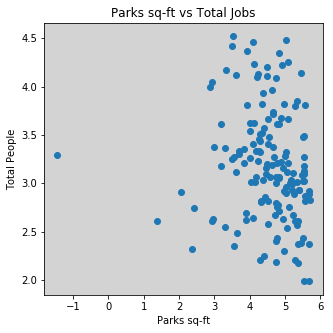

In [0]:
import math 

#=============================plot for nystate 
# ====# drop the variables when green_space=0

greenarea_size_temp = []
total_people_temp = []

for i in range(len(greenarea_size)):
  if greenarea_size[i] != 0 and total_people[i] != 0:
    greenarea_size_temp.append(greenarea_size[i])
    total_people_temp.append(total_people[i])
    

log10_greenarea_size = []
log10_total_people = []
for i in range(len(greenarea_size_temp)):
  log10_greenarea_size.append(math.log10(greenarea_size_temp[i]))
  log10_total_people.append(math.log10(total_people_temp[i]))
                                  
fig, ax = plt.subplots(figsize=(5, 5))

ax.set_title('Parks sq-ft vs Total Jobs')
ax.set_xlabel('Parks sq-ft')
ax.set_ylabel('Total People')
ax.set_facecolor("lightgray")
plt.scatter(log10_greenarea_size, log10_total_people)

In [0]:
import pyproj
from shapely.geometry import Point  

def area_fraction(geometry, lat, lon, rad):
  circle = Point(lat,lon).buffer(rad)
  inter = geometry.intersection(circle)  
  result = inter.area/geometry.area
  return result


manhattan = manhattan.to_crs(epsg=2263)  
gemo = manhattan['geometry']
lname = "drive/My Drive/lwir/data/nycdot/cams_latlon.npy"
latlon = np.load(lname)

def latlon_to_ny(lat, lon):
    """ lat/lon to NYS """

    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
    result = proj(lon, lat)

    return result


ny_lat, ny_lon = latlon_to_ny(latlon[:, 0], latlon[:, 1])
ny_latlon = np.vstack((ny_lat, ny_lon)).T



  
# #total_people = np.array(total_people)
# print(total_people)
rad = 500.
total_people_manhattan = []
for i in range(ny_latlon.shape[0]):
  jarea = area_fraction(gemo, ny_latlon[i][0], ny_latlon[i][1], rad)
  totaljobs = jarea * manhattan['total']
  jobstotal = totaljobs.sum()
  total_people_manhattan.append(jobstotal)
  
#total_people = np.array(total_people)
print(total_people_manhattan)

[0.0, 0.0, 0.0, 5239.605355543636, 0.0, 0.0, 20547.880379791866, 0.0, 5583.415766656208, 0.0, 0.0, 4139.695009976893, 0.0, 2748.4937592381966, 5910.363278840352, 0.0, 714.5044595923903, 0.0, 12288.998572349163, 2126.544345732951, 12189.36760977959, 19951.033172130898, 23219.880756315695, 26518.277277813715, 13969.084751438586, 16691.11164466323, 2448.8261558933755, 977.4507290286982, 1171.3209550231027, 356.85377446773225, 850.7692628933216, 1852.3422146771563, 1996.4073310987546, 3650.871060954546, 25021.776200210974, 8940.992289753056, 9857.639961005862, 0.0, 15883.108536767071, 12389.012553075692, 29452.289983368566, 14458.029559049997, 17123.910406827737, 26385.146858403103, 1157.5260136913532, 4963.416041005081, 45986.7681768972, 4919.029070182388, 23914.55836328345, 4180.003408843564, 17730.898875800824, 4596.37509964092, 4251.992463479257, 15147.70859887605, 29958.647066446658, 675.4973096010754, 1604.7493972166403, 1423.1390197740975, 7791.33241360777, 2377.570588654182, 650.13

In [0]:
def available_greenspace(geometry, lat, lon, rad):
  circle = Point(lat,lon).buffer(rad)
  parea = geometry.intersection(circle)   
  result = parea.area.sum()
  return result


fname = "drive/My Drive/lwir/data/parks/properties/geo_export_5b605687-0f81-4fe4-9fb7-ec27cd43ab5f.shp"

#read the godataframe and # -- Convert to NYSP coords

park = gp.GeoDataFrame.from_file(fname)
manhattan_park = park[park.borough == "M"]
manhattan_park = park.to_crs(epsg=2263) 
gemo = manhattan_park['geometry']




lname = "drive/My Drive/lwir/data/nycdot/cams_latlon.npy"
latlon = np.load(lname)
# len(latlon) #281

def latlon_to_ny(lat, lon):
    """ lat/lon to NYS """

    proj = pyproj.Proj(init="epsg:2263", preserve_units=True)
    result = proj(lon, lat)

    return result



ny_lat, ny_lon = latlon_to_ny(latlon[:, 0], latlon[:, 1])
ny_latlon = np.vstack((ny_lat, ny_lon)).T




rad = 500.


green_area_manhattan = []

for i in range(ny_latlon.shape[0]): #for in in range(len(latton))

  tarea = available_greenspace(gemo, ny_latlon[i][0], ny_latlon[i][1], rad)
  green_area_manhattan.append(tarea)

print(green_area_manhattan)
 


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

[0.0, 979.8064743176856, 0.0, 45023.62456460086, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 58445.16428738835, 0.0, 19998.479163659733, 0.0, 0.0, 27738.52437648816, 0.0, 0.0, 106125.95056684192, 55087.99869758377, 0.0, 8320.291016319372, 0.0, 275257.69398205954, 0.0, 0.0, 157510.83975452487, 66006.33318213576, 0.0, 160457.4507086348, 0.0, 5065.4175646376825, 0.0, 0.0, 0.0, 774.7542460965503, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3181.931609328875, 15459.035162358396, 0.0, 0.0, 0.0, 0.0, 9901.365924108217, 0.0, 0.0, 0.0, 0.0, 107791.03341599465, 514710.04717474314, 6959.067569210872, 85853.0714735885, 0.0, 0.0, 0.0, 0.0, 0.0, 89724.2388952635, 0.0, 46133.939657332485, 76137.13705631309, 23405.802278549065, 0.0, 32399.135984912533, 5048.691858165191, 0.0, 0.0, 0.0, 0.0, 65605.86242678041, 23.604972735422823, 0.0, 0.0, 0.0, 341611.1816233444, 340411.0756514045, 0.0, 0.0, 337377.13809223304, 119475.6375219297, 31554.40163325733, 0.0, 3306.7293711453185, 55231.85039356697, 1533.9693687962922, 878.117842640

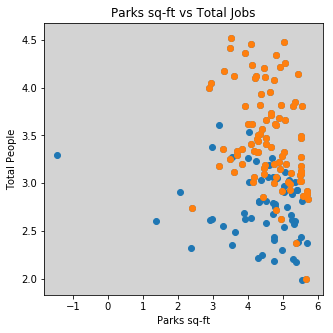

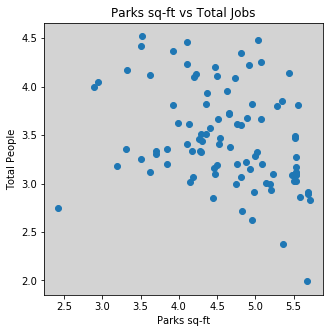

In [0]:

#=============================plot for manhattan

green_area_manhattan_temp = []
total_people_manhattan_temp = []

for i in range(len(green_area_manhattan)):
  if (green_area_manhattan[i] != 0 and total_people_manhattan[i] != 0):
    green_area_manhattan_temp.append(green_area_manhattan[i])
    total_people_manhattan_temp.append(total_people_manhattan[i])
    
    
import math 
fname = []
log10_green_area_manhattan = []
log10_total_people_manhattan = []
for i in range(len(green_area_manhattan_temp)):
  log10_green_area_manhattan.append(math.log10(green_area_manhattan_temp[i]))
  log10_total_people_manhattan.append(math.log10(total_people_manhattan_temp[i]))
#=============================plot for manhattan vs ny state  
fig, ax = plt.subplots(figsize=(5, 5))

ax.set_title('Parks sq-ft vs Total Jobs')
ax.set_xlabel('Parks sq-ft')
ax.set_ylabel('Total People')
ax.set_facecolor("lightgray")
plt.scatter(log10_greenarea_size, log10_total_people)
plt.scatter(log10_green_area_manhattan,  log10_total_people_manhattan)

#=============================plot for manhattan

fig, ax = plt.subplots(figsize=(5, 5))

ax.set_title('Parks sq-ft vs Total Jobs')
ax.set_xlabel('Parks sq-ft')
ax.set_ylabel('Total People')
ax.set_facecolor("lightgray")
plt.scatter(log10_green_area_manhattan,  log10_total_people_manhattan)

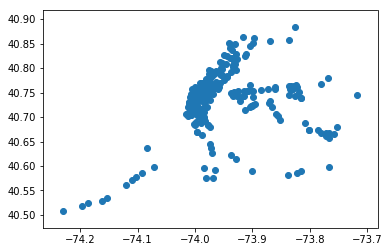

In [0]:
#=============== the lon/lat for the camera location

ax.set_title('Camera Location')
ax.set_xlabel('lon')
ax.set_ylabel('lat')
plt.scatter(latlon[:, 1], latlon[:, 0])